In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time


In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transforms.Compose([transforms.ToTensor()]))
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/test', transform=transforms.Compose([transforms.ToTensor()]))
valid_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/valid', transform=transforms.Compose([transforms.ToTensor()]))

In [6]:
train_data[0][0].shape

torch.Size([3, 640, 640])

In [7]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=1)
hold_out_test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [8]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))
print((hold_out_test_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


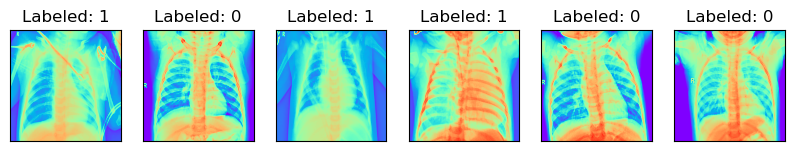

In [9]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [10]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 128, kernel_size=5)
        self.conv2 = Conv2d(128, 128, kernel_size=3)
        self.conv3 = Conv2d(128,128,kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(758912, 128)
        self.fc2 = Linear(128, 2)
        self.fc3 = Linear(2,1) # Replacing quantum circuit with linear
        self.fc4 = Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)  # QNN in foward section
        x = self.fc4(x)
        return cat((x, 1 - x), -1)

model = Net()

In [11]:
model = model.to('cuda')

In [12]:
print(model)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=758912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
  (fc4): Linear(in_features=1, out_features=1, bias=True)
)


In [13]:
summary(model, (3, 640, 640),  device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 316, 316]       147,584
├─Conv2d: 1-3                            [-1, 128, 154, 154]       409,728
├─Dropout2d: 1-4                         [-1, 128, 77, 77]         --
├─Linear: 1-5                            [-1, 128]                 97,140,864
├─Linear: 1-6                            [-1, 2]                   258
├─Linear: 1-7                            [-1, 1]                   3
├─Linear: 1-8                            [-1, 1]                   2
Total params: 97,708,167
Trainable params: 97,708,167
Non-trainable params: 0
Total mult-adds (G): 28.42
Input size (MB): 4.69
Forward/backward pass size (MB): 515.69
Params size (MB): 372.73
Estimated Total Size (MB): 893.11


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 636, 636]       9,728
├─Conv2d: 1-2                            [-1, 128, 316, 316]       147,584
├─Conv2d: 1-3                            [-1, 128, 154, 154]       409,728
├─Dropout2d: 1-4                         [-1, 128, 77, 77]         --
├─Linear: 1-5                            [-1, 128]                 97,140,864
├─Linear: 1-6                            [-1, 2]                   258
├─Linear: 1-7                            [-1, 1]                   3
├─Linear: 1-8                            [-1, 1]                   2
Total params: 97,708,167
Trainable params: 97,708,167
Non-trainable params: 0
Total mult-adds (G): 28.42
Input size (MB): 4.69
Forward/backward pass size (MB): 515.69
Params size (MB): 372.73
Estimated Total Size (MB): 893.11

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')


epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Models/trainCNN_ChestCopy.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")

toc = time.time()

Training [6%]	Loss: 0.3241	Accuracy: 86.22%
Saving model with test loss of 93.279
Training [12%]	Loss: 0.1757	Accuracy: 93.28%
Training [19%]	Loss: 0.1544	Accuracy: 94.24%
Saving model with test loss of 95.119
Training [25%]	Loss: 0.1361	Accuracy: 95.12%
Saving model with test loss of 95.193
Training [31%]	Loss: 0.1253	Accuracy: 95.19%
Training [38%]	Loss: 0.1040	Accuracy: 96.27%
Saving model with test loss of 96.321
Training [44%]	Loss: 0.1016	Accuracy: 96.32%
Saving model with test loss of 96.689
Training [50%]	Loss: 0.0883	Accuracy: 96.69%
Training [56%]	Loss: 0.0730	Accuracy: 97.35%
Saving model with test loss of 97.940
Training [62%]	Loss: 0.0578	Accuracy: 97.94%
Training [69%]	Loss: 0.0528	Accuracy: 98.14%
Saving model with test loss of 98.872
Training [75%]	Loss: 0.0350	Accuracy: 98.87%
Saving model with test loss of 98.675
Training [81%]	Loss: 0.0328	Accuracy: 98.68%
Training [88%]	Loss: 0.0263	Accuracy: 99.04%
Saving model with test loss of 99.092
Training [94%]	Loss: 0.0247	A

In [15]:
model_path = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Models/trainCNN_ChestCopy.pt'

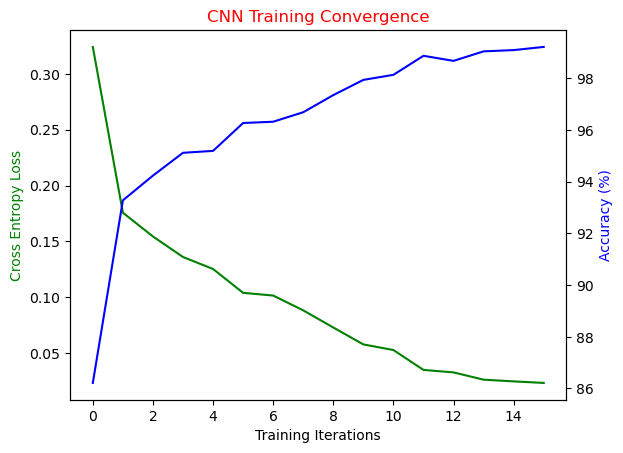

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("CNN Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [17]:
torch.save(model.state_dict(), model_path)

In [18]:
model1 = Net()
model1.load_state_dict(torch.load(model_path))
model1= model1.to('cuda')

In [19]:
batch_size=1

model1.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model1(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1248
	Accuracy: 96.05%
[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,

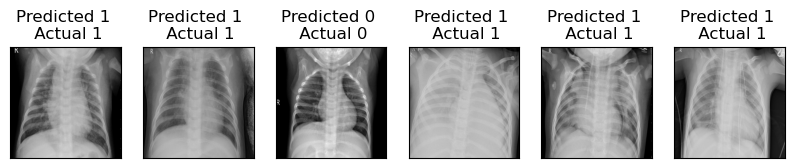

In [20]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model1.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model1(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [21]:
time_taken = toc-tic

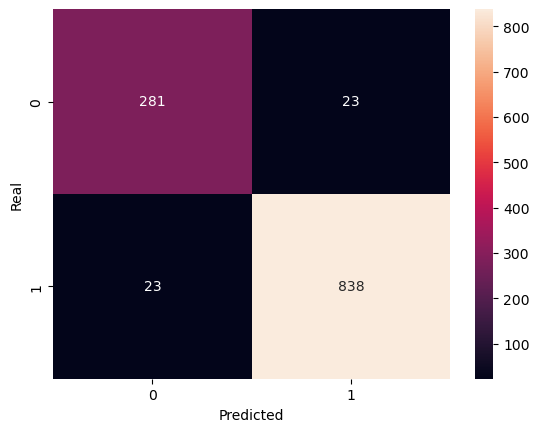

Time taken:  10609.296319246292
Test size: 1165
Total Accuracy:  0.9605150214592275
Total Precision:  0.9732868757259001
Total Recall:  0.9732868757259001
Total F1 Score:  0.9732868757259
Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       304
           1       0.97      0.97      0.97       861

    accuracy                           0.96      1165
   macro avg       0.95      0.95      0.95      1165
weighted avg       0.96      0.96      0.96      1165



In [22]:
val_CNN = matrix_confusion(test_targets, pred_targets,time_taken)

In [23]:
out = pd.DataFrame([val_CNN],
                   index = ['CNN'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
out.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
CNN,10609.296319,0.960515,0.973287,0.973287,0.973287
